# Dynamic Programming (DP)

##### Bellman Image

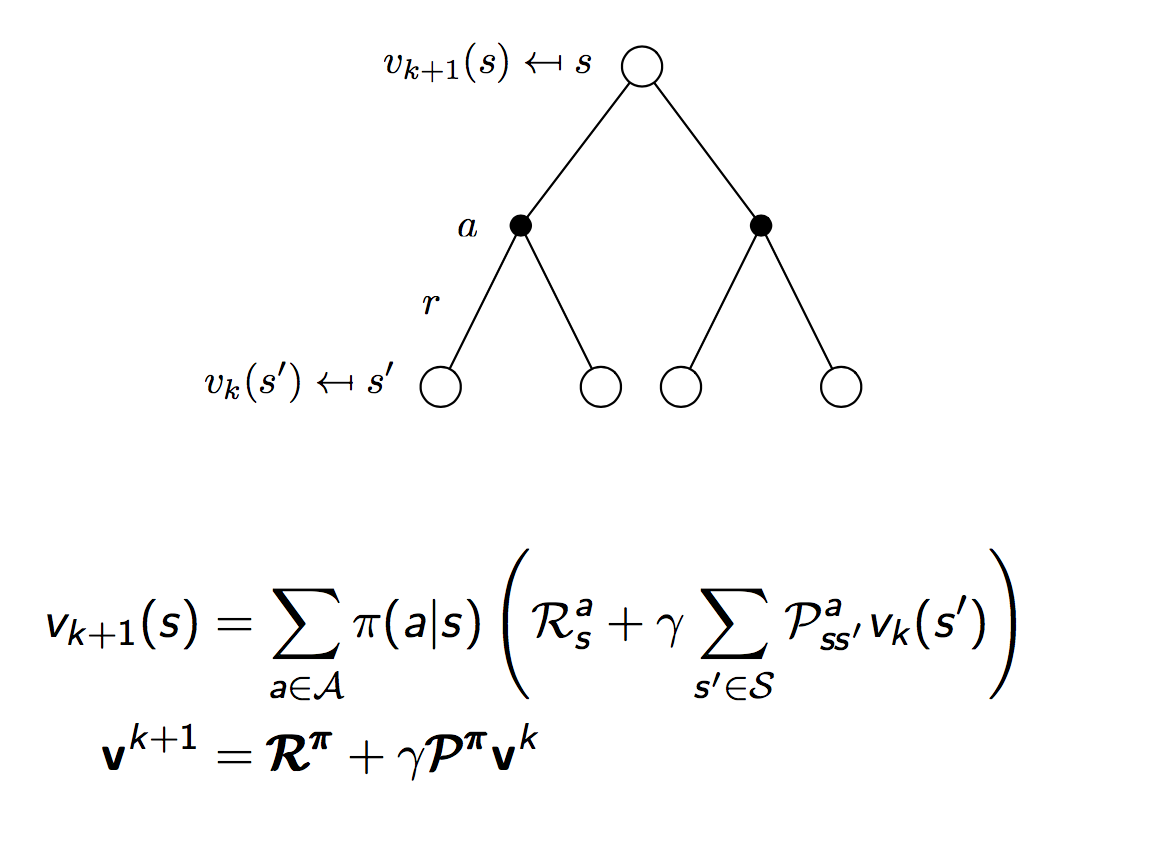

## Problem - Small Gridworld

##### Code

* $S=\{,1,2,3,...,14\}$
* $A=\{up, right, down, left\}$
* $\gamma=1$
* $R=r(s,a,s')=-1$
* equiprobable random policy (all actions equally like)

##### Image

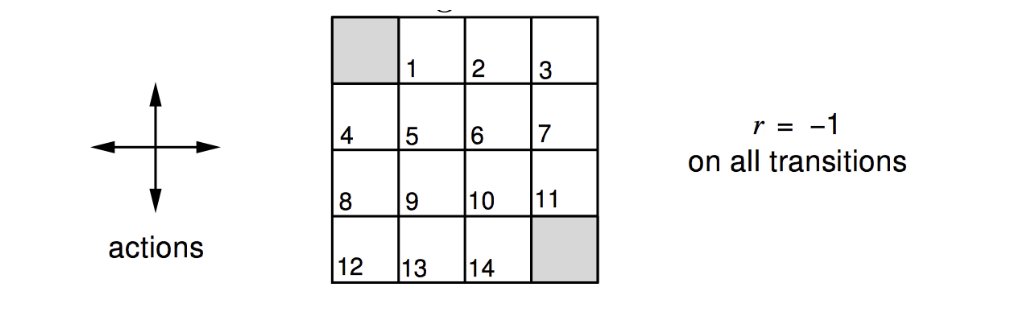

In [1]:
import numpy as np
import pprint
from environments.gridworld import GridworldEnv

In [2]:
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

In [3]:
# states = [print(env.P[s]) for s in range(env.nS)]

## Policy Iteration

### Policy Evaluation

#### Bellman optimality equations $v_*, q_*$

$v_*(s)=\max_{a}\mathbb{E}[R_{t+1}+\gamma v_*(S_{t+1})|S_t=s, A_t+a]$

$ =\max_{a} \sum_{s', r}p(s',r|s,a)[r+\gamma v_*(s')]$
___
$q_*(s,a)=\mathbb{E}[R_{t+1}+\gamma \max_{a'}q_*(S_{t+1},a')|S_t=s,A_t=a]$

$=\sum_{s',r}p(s',r|s,a)[r+\gamma \max_{a'}q_*(s',s')]$

#### Policy Evaluation $v_\pi$

state-value function $v_\pi$ for arbitrary policy $\pi$:

$v_\pi(s)=\mathbb{E}_\pi[G_t|S_t=s]$

$=\mathbb{E}_\pi[R_{t+1}+\gamma G_{t+1}|S_t=s]$

$=\mathbb{E}_\pi[R_{t+1}+\gamma v_\pi(S_{t+1}|S_t=s]$

$=\sum_{a}\pi(a|s)\sum_{s',r}p(s',r|s,a)[r+\gamma v_\pi(s')]$

#### Iterative Policy Evaluation (Successive approximation) $v_{k+1}$

$v_{k+1}(s)=\mathbb{E}_\pi[R_{t+1}+\gamma v_k(S_{t+1}|S_t=s]$

$=\sum_{a}\pi(a|s)\sum_{s',r}p(s',r|s,a)[r+\gamma v_\pi(s')]$

Vectorized version:

$v_{k+1}(s) = \sum_{a \in A} \pi(a|s)(R_s^a + \gamma \sum_{s' \in S} P_{ss'}^a v_k(s'))$

$v_{k+1} = R^\pi + \gamma P^\pi v_k $

#### Algorithm

Input $\pi$

Initialize an array $V(s)=0$, for all $s \in S^+$

**Repeat**
* $\Delta \leftarrow 0$

    For each $s \in S$:
    * $v \leftarrow V(s)$
    * $V(s) \leftarrow\sum_a\pi(a|s)\sum_{s',r}p(s',r|s,a)[r+\gamma V(s')]$
    * $\Delta\leftarrow max(\Delta,|v-V(s)|)$
    
**until** $\Delta < \theta$ (a small positive number)

Output $V \approx v_\pi$

#### Code

##### Standard

In [69]:
def policy_eval(env, policy, discount_factor=1.0, theta=1e-5):
    # initialize V(s) = 0
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # perform full backup on each state
        for s in range(env.nS):
            v = 0
            # one-step lookahead
            for a, a_prob in enumerate(policy[s]):
                for prob, s_next, reward, done in env.P[s][a]:
                    v += (a_prob*prob) * (reward+discount_factor*V[s_next])
            
            delta = max(delta, np.abs(v-V[s]))
            V[s] = v
            
        if delta<theta:
            break
    return np.array(V)

##### Vectorized

In [66]:
# def policy_eval(env, policy, discount_factor=1.0, theta=1e-5):
# #     V = np.zeros(env.nS)
# #     pi = np.array(policy)
# #     r = np.zeros((env.nS, env.nA))
    
#     for s in range(env.nS):
#         print(env.P[s])

In [70]:
policy1 = np.ones([env.nS, env.nA]) / env.nA

In [71]:
v = policy_eval(env, policy1)

In [72]:
print("Value Function:")
print(v)
print("")
print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Value Function:
[  0.         -13.99993529 -19.99990698 -21.99989761 -13.99993529
 -17.9999206  -19.99991379 -19.99991477 -19.99990698 -19.99991379
 -17.99992725 -13.99994569 -21.99989761 -19.99991477 -13.99994569   0.        ]

Reshaped Grid Value Function:
[[  0.         -13.99993529 -19.99990698 -21.99989761]
 [-13.99993529 -17.9999206  -19.99991379 -19.99991477]
 [-19.99990698 -19.99991379 -17.99992725 -13.99994569]
 [-21.99989761 -19.99991477 -13.99994569   0.        ]]



In [8]:
# Test: Make sure the evaluated policy is what we expected
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

### Policy Improvement

#### Test policy $q_\pi(s,a)$

Test policy by selecting $a$ in $s$, when following $\pi$:

$q_\pi(s,a) = \mathbb{E}_\pi[R_{t+1}+\gamma V_\pi(S_{t+1})|S_t=s, A_t=a] $

$ = \sum_{s',r} p(s',r|s,a)[r+\gamma v_\pi(s')]$

#### Greedy policy $\pi'$

$ \pi'(s) = argmax_{a} q_\pi(s,a) $

$=argmax_a \mathbb{E}[R_t+1 + \gamma v_\pi(s_{t+1})|S_t=s, A_t=a]$

$=argmax_a \sum_{s',r} p(s',r|s,a)[r+\gamma v_\pi(s')]$

#### Policy Improvement (greedy) $\pi'$

$ v_{\pi'}(s) = \max_{a} \mathbb{E}[R_{t+1}+\gamma v_{\pi'}(S_{t+1})|S_t=s,A_t=a]$

$ =\max_{a} \sum_{s', r}p(s',r|s,a)[r+\gamma v_\pi'(s')] $

#### Algorithm

policy-stable $\leftarrow$ true

For each $s\in S$:
* old-action $\leftarrow \pi(s)$
* $\pi(s)\leftarrow argmax_a\sum_{s',r} p(s',r|s,a)[r+\gamma V(s')$
* If old-action $\neq \pi(s)$, the policy-stable$\leftarrow$ false 

#### Code

In [9]:
def policy_improvement(env, eval_fn=policy_eval, discount_factor=1.0):
    # random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        # Evaluate current policy
        V = policy_eval(env, policy, discount_factor)
        policy_stable = True
        
        for s in range(env.nS):
            chosen_a = np.argmax(policy[s])
            
            # find the best action by one-step lookahead
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for prob, next_s, reward, done in env.P[s][a]:
                    action_values[a] += prob*(reward+discount_factor*V[next_s])
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        # We've found the optimal policy
        if policy_stable:
            return policy, V

In [10]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [11]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

### Policy Iteration

#### Algorithm

1. Initialization: $V(s) \in \mathbb{R}$ and $\pi(s) \in \mathbb{A}(s)$ arbitrarily for all $s\in S$
2. Policy Evaluation
3. Policy Improvement: If policy-stable, then stop and return $V \approx v_*$ and $\pi \approx \pi_*$; else do **step 2**

## Value Iteration

### Value Iteration $v_{k+1}$

$v_{k+1}(s)=\max_{a}\mathbb{E}[R_{t+1}+\gamma v_k(S_{t+1})|S_t=s, A_t=a]$

$=\max_a\sum_{s',r}p(s',r,|s,a)[r+\gamma v_k(s')]$

Vectorized version:

$v_{k+1}(s)=max_{a\in A}(R_s^a + \gamma \sum_{s'\in S}P_{ss'}^a v_k(s'))$

$v_{k+1}=\max_{a\in A}R^a + \gamma P^a v_k$

#### Algo

Initialize array $V$ arbitrarily (e.g., $V(s)=s$ for all $s\in S^+$)

**Repeat**

$\Delta \leftarrow 0$
For each $s\in S$:
* $v \leftarrow V(s)$
* $V(s) \leftarrow \max_a\sum_{s',r} p(s',r|s,a)[r+\gamma V(s')]$

**until** $\Delta < \theta$ (a small positive number)
Output a deterministic policy, $\pi \approx \pi_*$, such that

* $\pi(s)=argmax_a\sum_{s',r}p(s',r|s,a)[r+\gamma V(s')$

#### Code

In [12]:
def value_iteration(env, discount_factor=1.0, theta=1e-4):
    def one_step_look(state, V):
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_s, reward, done in env.P[state][a]:
                A[a] += prob*(reward+discount_factor*V[next_s])
        return A
    
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            A = one_step_look(s, V)
            best_a = np.max(A)
            delta = max(delta, np.abs(best_a - V[s]))
            V[s] = best_a
        
        if delta < theta:
            break
    
    # create deterministic policy using v*
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        A = one_step_look(s, V)
        best_a = np.argmax(A)
        policy[s, best_a] = 1.0
    
    return policy,v

In [13]:
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]

